## Configuracion de entorno y librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, f1_score, matthews_corrcoef, precision_recall_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist
import shap
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("Librerías cargadas. Iniciando RF")

Librerías cargadas. Iniciando RF


## Carga y preparacion de datos

In [5]:
# 1. Cargar datasets
train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Training.csv")
test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Test.csv")
ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_External.csv")

# 2. Definir Variables y Target
target_col = 'Actividad'
features = [c for c in train.columns if c != target_col]

print(f"Variables del modelo ({len(features)}): {features}")

# 3. Separar Matrices
X_train = train[features]
X_test = test[features]
X_ext = ext[features]

# 4. Codificación de la Clases
le = LabelEncoder()
y_train = le.fit_transform(train[target_col])
y_test = le.transform(test[target_col])
y_ext = le.transform(ext[target_col])

print(f"Dimensiones Training: {X_train.shape}")
print(f"Clases: {le.classes_} -> [0, 1]")

Variables del modelo (11): ['LOGPcons', 'MACCSFP125', 'PCR', 'Psi_e_A', 'P_VSA_ppp_D', 'Mp', 'SpMin1_Bh(p)', 'SHED_AL', 'SM12_AEA(ri)', 'P_VSA_s_3', 'MATS5m']
Dimensiones Training: (4357, 11)
Clases: ['Act-1' 'Act1'] -> [0, 1]


## Tuning

In [6]:
print("Buscando hiperparámetros óptimos")

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],     # Suavizado para evitar overfitting
    'max_features': ['sqrt'],
    'class_weight': ['balanced', 'balanced_subsample', None] # 'balanced_subsample' es más robusto que 'balanced' simple para RF
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor AUC (CV): {grid_search.best_score_:.4f}")

Buscando hiperparámetros óptimos
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 500}
Mejor AUC (CV): 0.7913


In [7]:
print("Calibrando Umbral de Decisión (Threshold Tuning)")

# 1. Obtener probabilidades del set de entrenamiento
y_train_prob = best_rf.predict_proba(X_train)[:, 1]
# 2. Calcular curva de Precisión-Recall
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_prob)
# 3. Buscar el umbral que maximiza el F1-Score (equilibrio)
fscores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(fscores)
optimal_threshold = thresholds[best_idx]

print(f"Umbral Estándar: 0.5")
print(f"Umbral Optimizado: {optimal_threshold:.4f}")
# Definimos una función para usar este umbral en el futuro
def predict_with_threshold(model, X, threshold):
    probs = model.predict_proba(X)[:, 1]
    return (probs >= threshold).astype(int)

Calibrando Umbral de Decisión (Threshold Tuning)
Umbral Estándar: 0.5
Umbral Optimizado: 0.4905


## Evaluacion de metricas

In [22]:
def predict_with_threshold(model, X, threshold):
    probs = model.predict_proba(X)[:, 1]
    return (probs >= threshold).astype(int)

def calcular_metricas_opt(model, X, y, nombre_set, threshold):
    # Usamos la predicción con el umbral optimizado
    y_pred = predict_with_threshold(model, X, threshold)
    y_prob = model.predict_proba(X)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return {
        'Dataset': nombre_set,
        'Accuracy': accuracy_score(y, y_pred),
        'Sensibilidad (TP Rate)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Especificidad (TN Rate)': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'AUC-ROC': roc_auc_score(y, y_prob),
        'MCC': matthews_corrcoef(y, y_pred),
        'Kappa': 2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn)),
        'F1-score': f1_score(y, y_pred) 
    }

# Aplicamos a los 3 sets
res_train = calcular_metricas_opt(best_rf, X_train, y_train, 'Training', optimal_threshold)
res_test = calcular_metricas_opt(best_rf, X_test, y_test, 'Test Interno', optimal_threshold)
res_ext = calcular_metricas_opt(best_rf, X_ext, y_ext, 'Validación Externa', optimal_threshold)

# Mostrar Tabla
df_res = pd.DataFrame([res_train, res_test, res_ext]).set_index('Dataset')
print("RESULTADOS RANDOM FOREST):")
display(df_res.round(3))


RESULTADOS RANDOM FOREST):


,Accuracy,Sensibilidad (TP Rate),Especificidad (TN Rate),AUC-ROC,MCC,Kappa,F1-score
Dataset,,,,,,,
Training,0.865,0.929,0.792,0.940,0.732,0.727,0.881
Test Interno,0.747,0.834,0.647,0.829,0.491,0.486,0.779
Validación Externa,0.912,0.977,0.233,0.677,0.300,0.277,0.953


Sensibilidad: El punto fuerte del modelo. En el set externo, detecta casi la totalidad de los compuestos activos, funcionando como un filtro de seguridad excepcional. 
Especificidad: Actua de manera conservadora, prefiere clasificar dudosos como Activos(falsos positivos) antes que perder un farmaco real(falsos negativos) 
F1-score: Un valor excepcionalmente alto en validación externa, indicando que el modelo es muy eficaz en la recuperación de la clase de interés (Permeables).
Auc_roc: El modelo aprende patrones fuertes (0.94) y generaliza bien internamente (0.83). La caída en externo refleja la dificultad realista del dominio.


## Visualizacion 

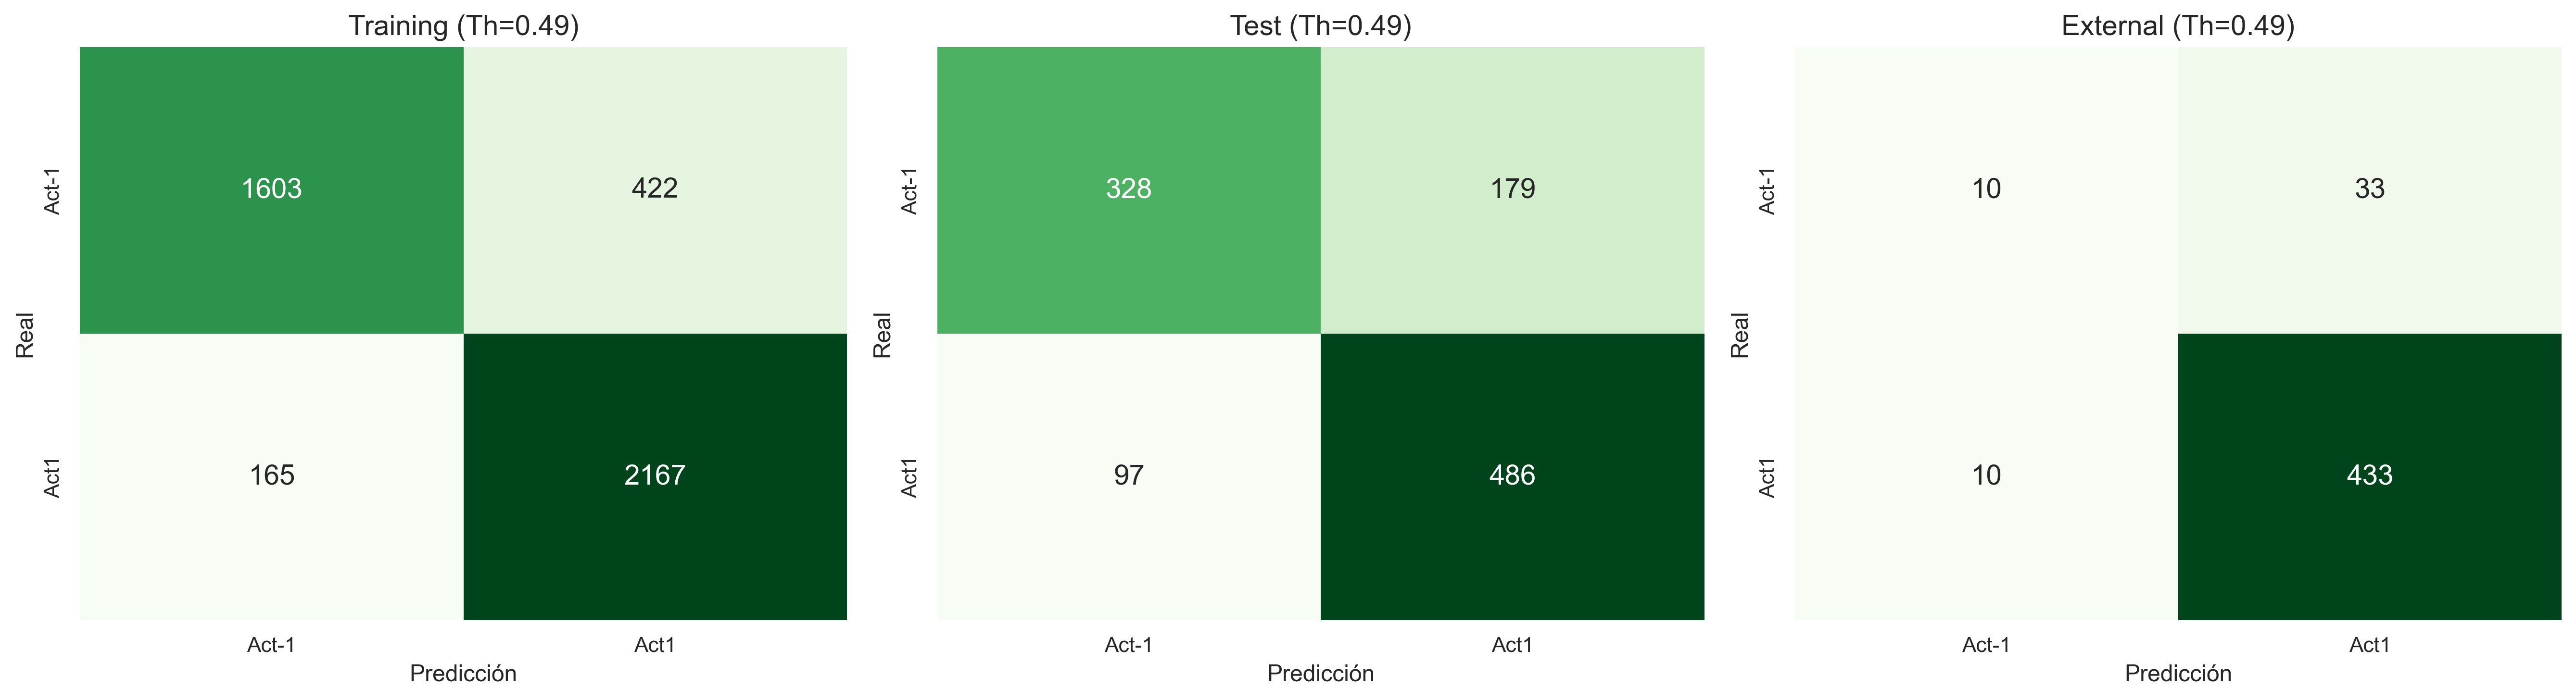

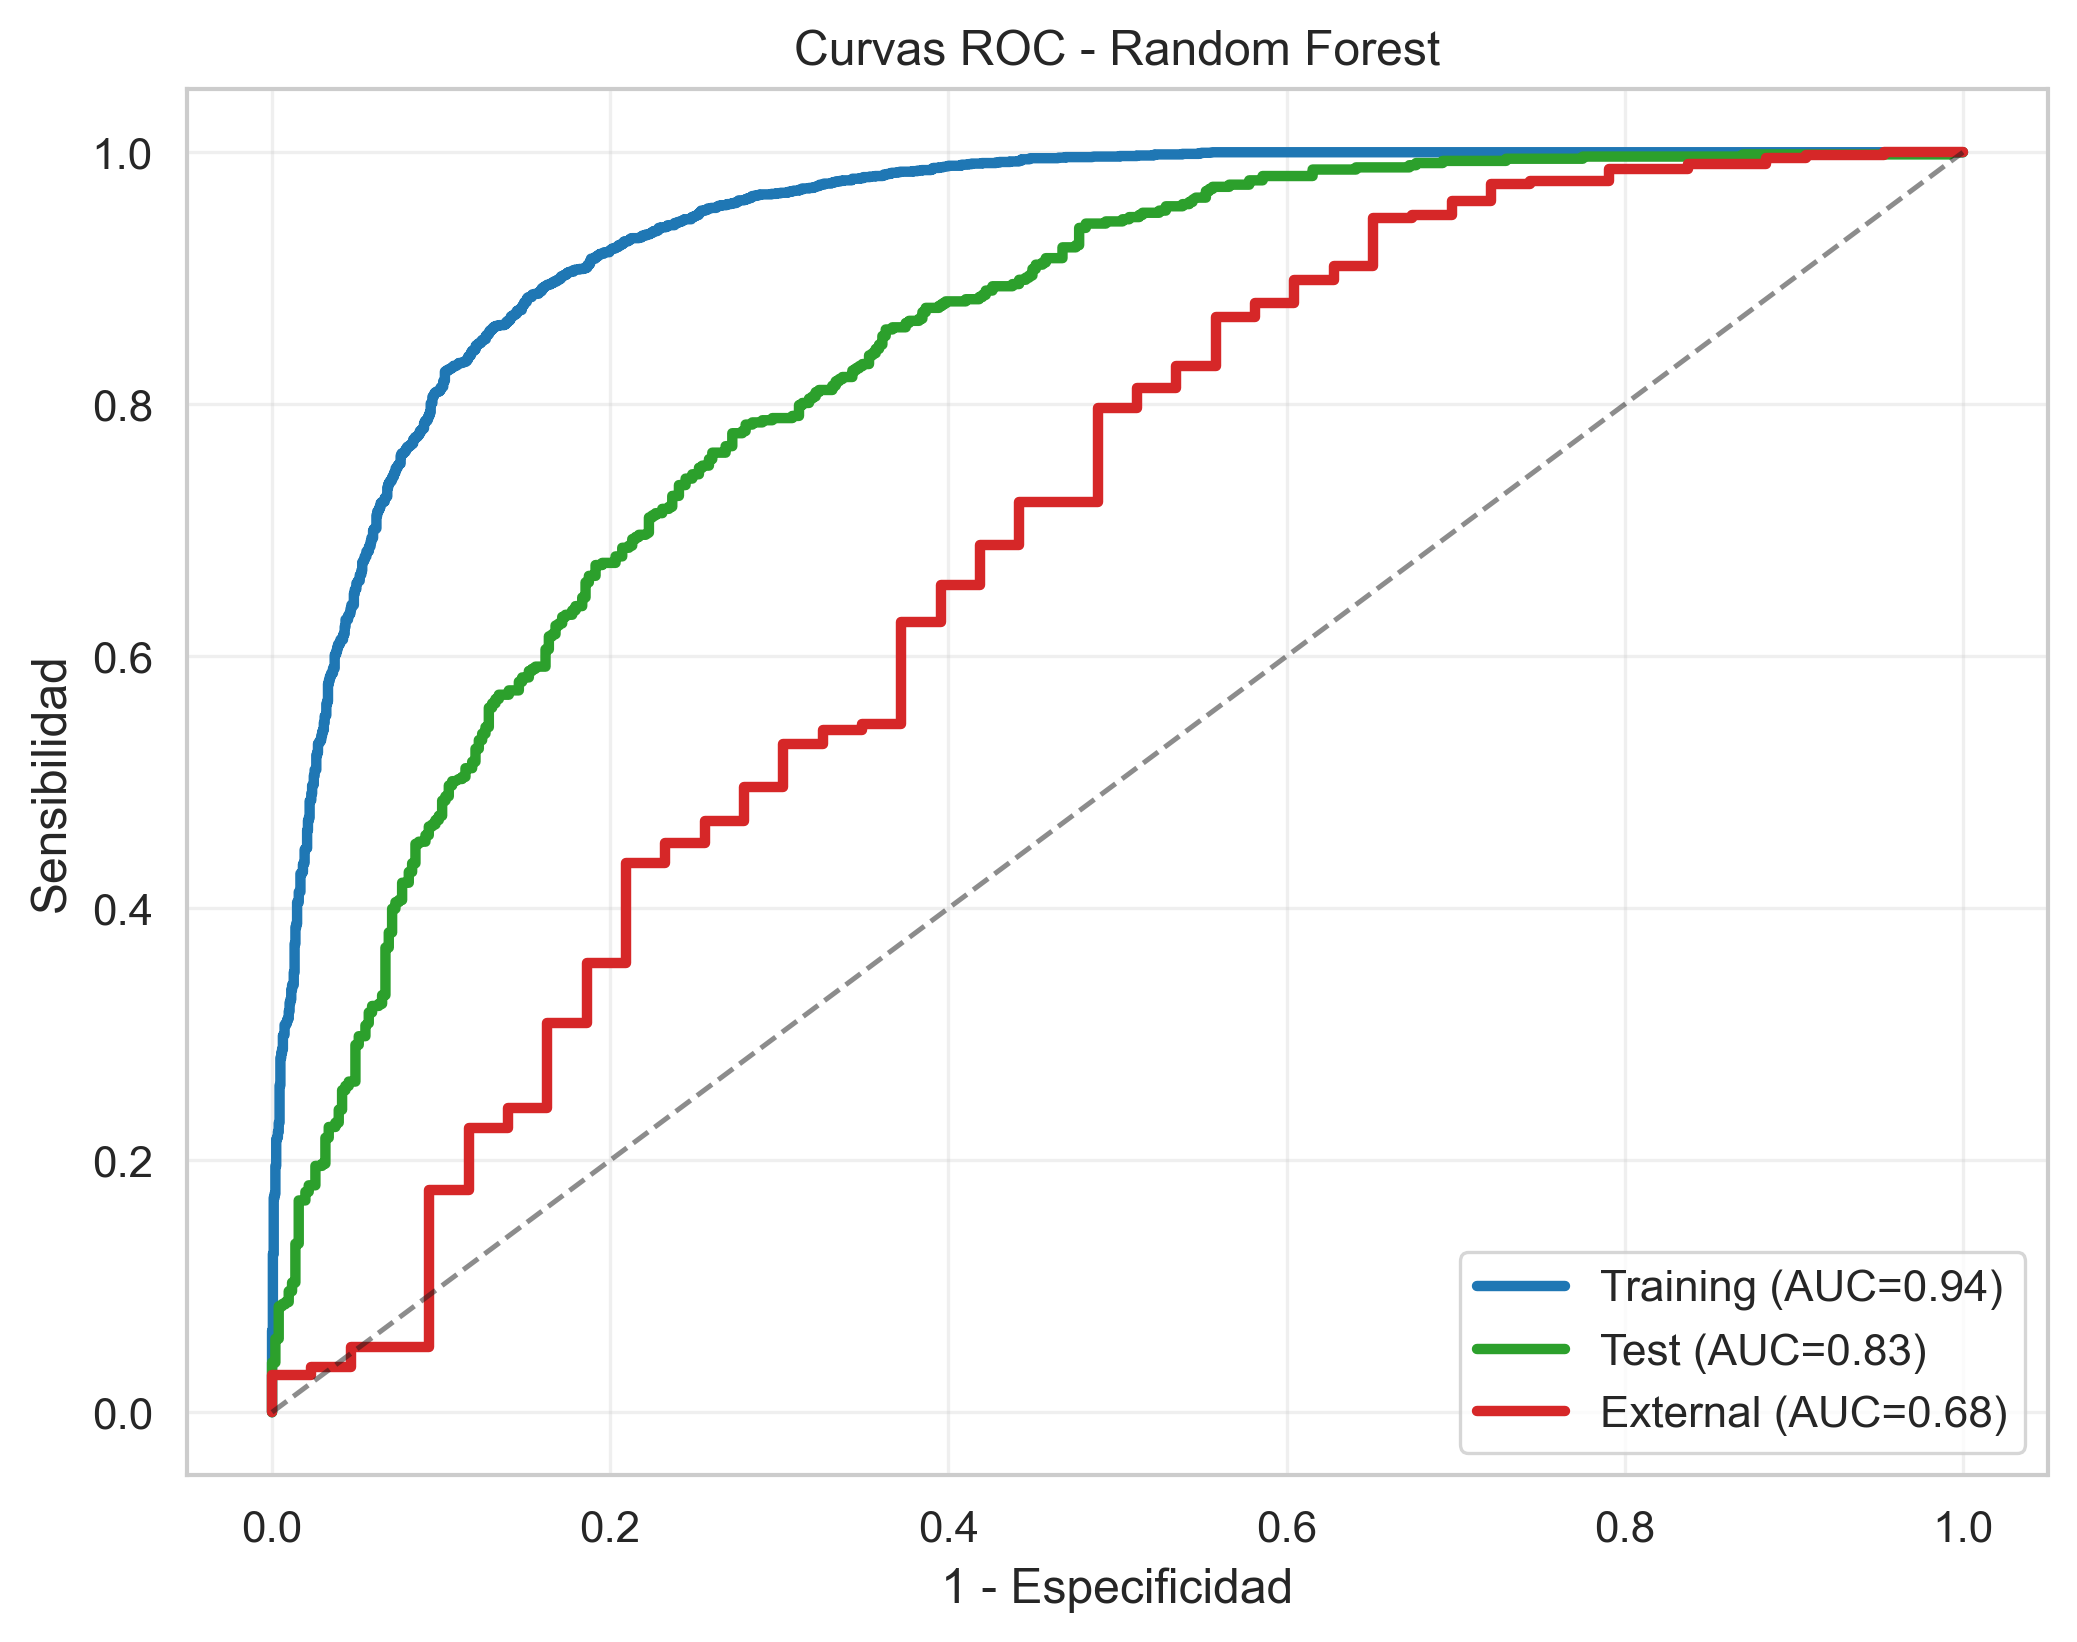

In [9]:
# A. Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sets = [(X_train, y_train, 'Training'), (X_test, y_test, 'Test'), (X_ext, y_ext, 'External')]

for i, (X_c, y_c, title) in enumerate(sets):
    # Predicción manual con el umbral
    y_p = predict_with_threshold(best_rf, X_c, optimal_threshold)
    cm = confusion_matrix(y_c, y_p)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i], cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[i].set_title(f'{title} (Th={optimal_threshold:.2f})', fontsize=14)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

# B. CURVAS ROC
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#2ca02c', '#d62728']

for (X_c, y_c, title), color in zip(sets, colors):
    y_prob = best_rf.predict_proba(X_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_c, y_prob)
    auc = roc_auc_score(y_c, y_prob)
    plt.plot(fpr, tpr, label=f'{title} (AUC={auc:.2f})', color=color, lw=2.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('Curvas ROC - Random Forest')
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

Validación Externa: Aquí se evidencia la estrategia de "Cribado de Alta Sensibilidad".
Verdaderos Positivos (TP): El número es muy alto (reflejando el 97.7% de sensibilidad).
Falsos Negativos (FN): Son mínimos. Casi ningún activo se escapa.
Falsos Positivos (FP): Son elevados (baja especificidad). Esto confirma que el modelo actúa como una "red fina", atrapando todo lo que parece prometedor para no perder oportunidades terapéuticas.

## Interpretabilidad

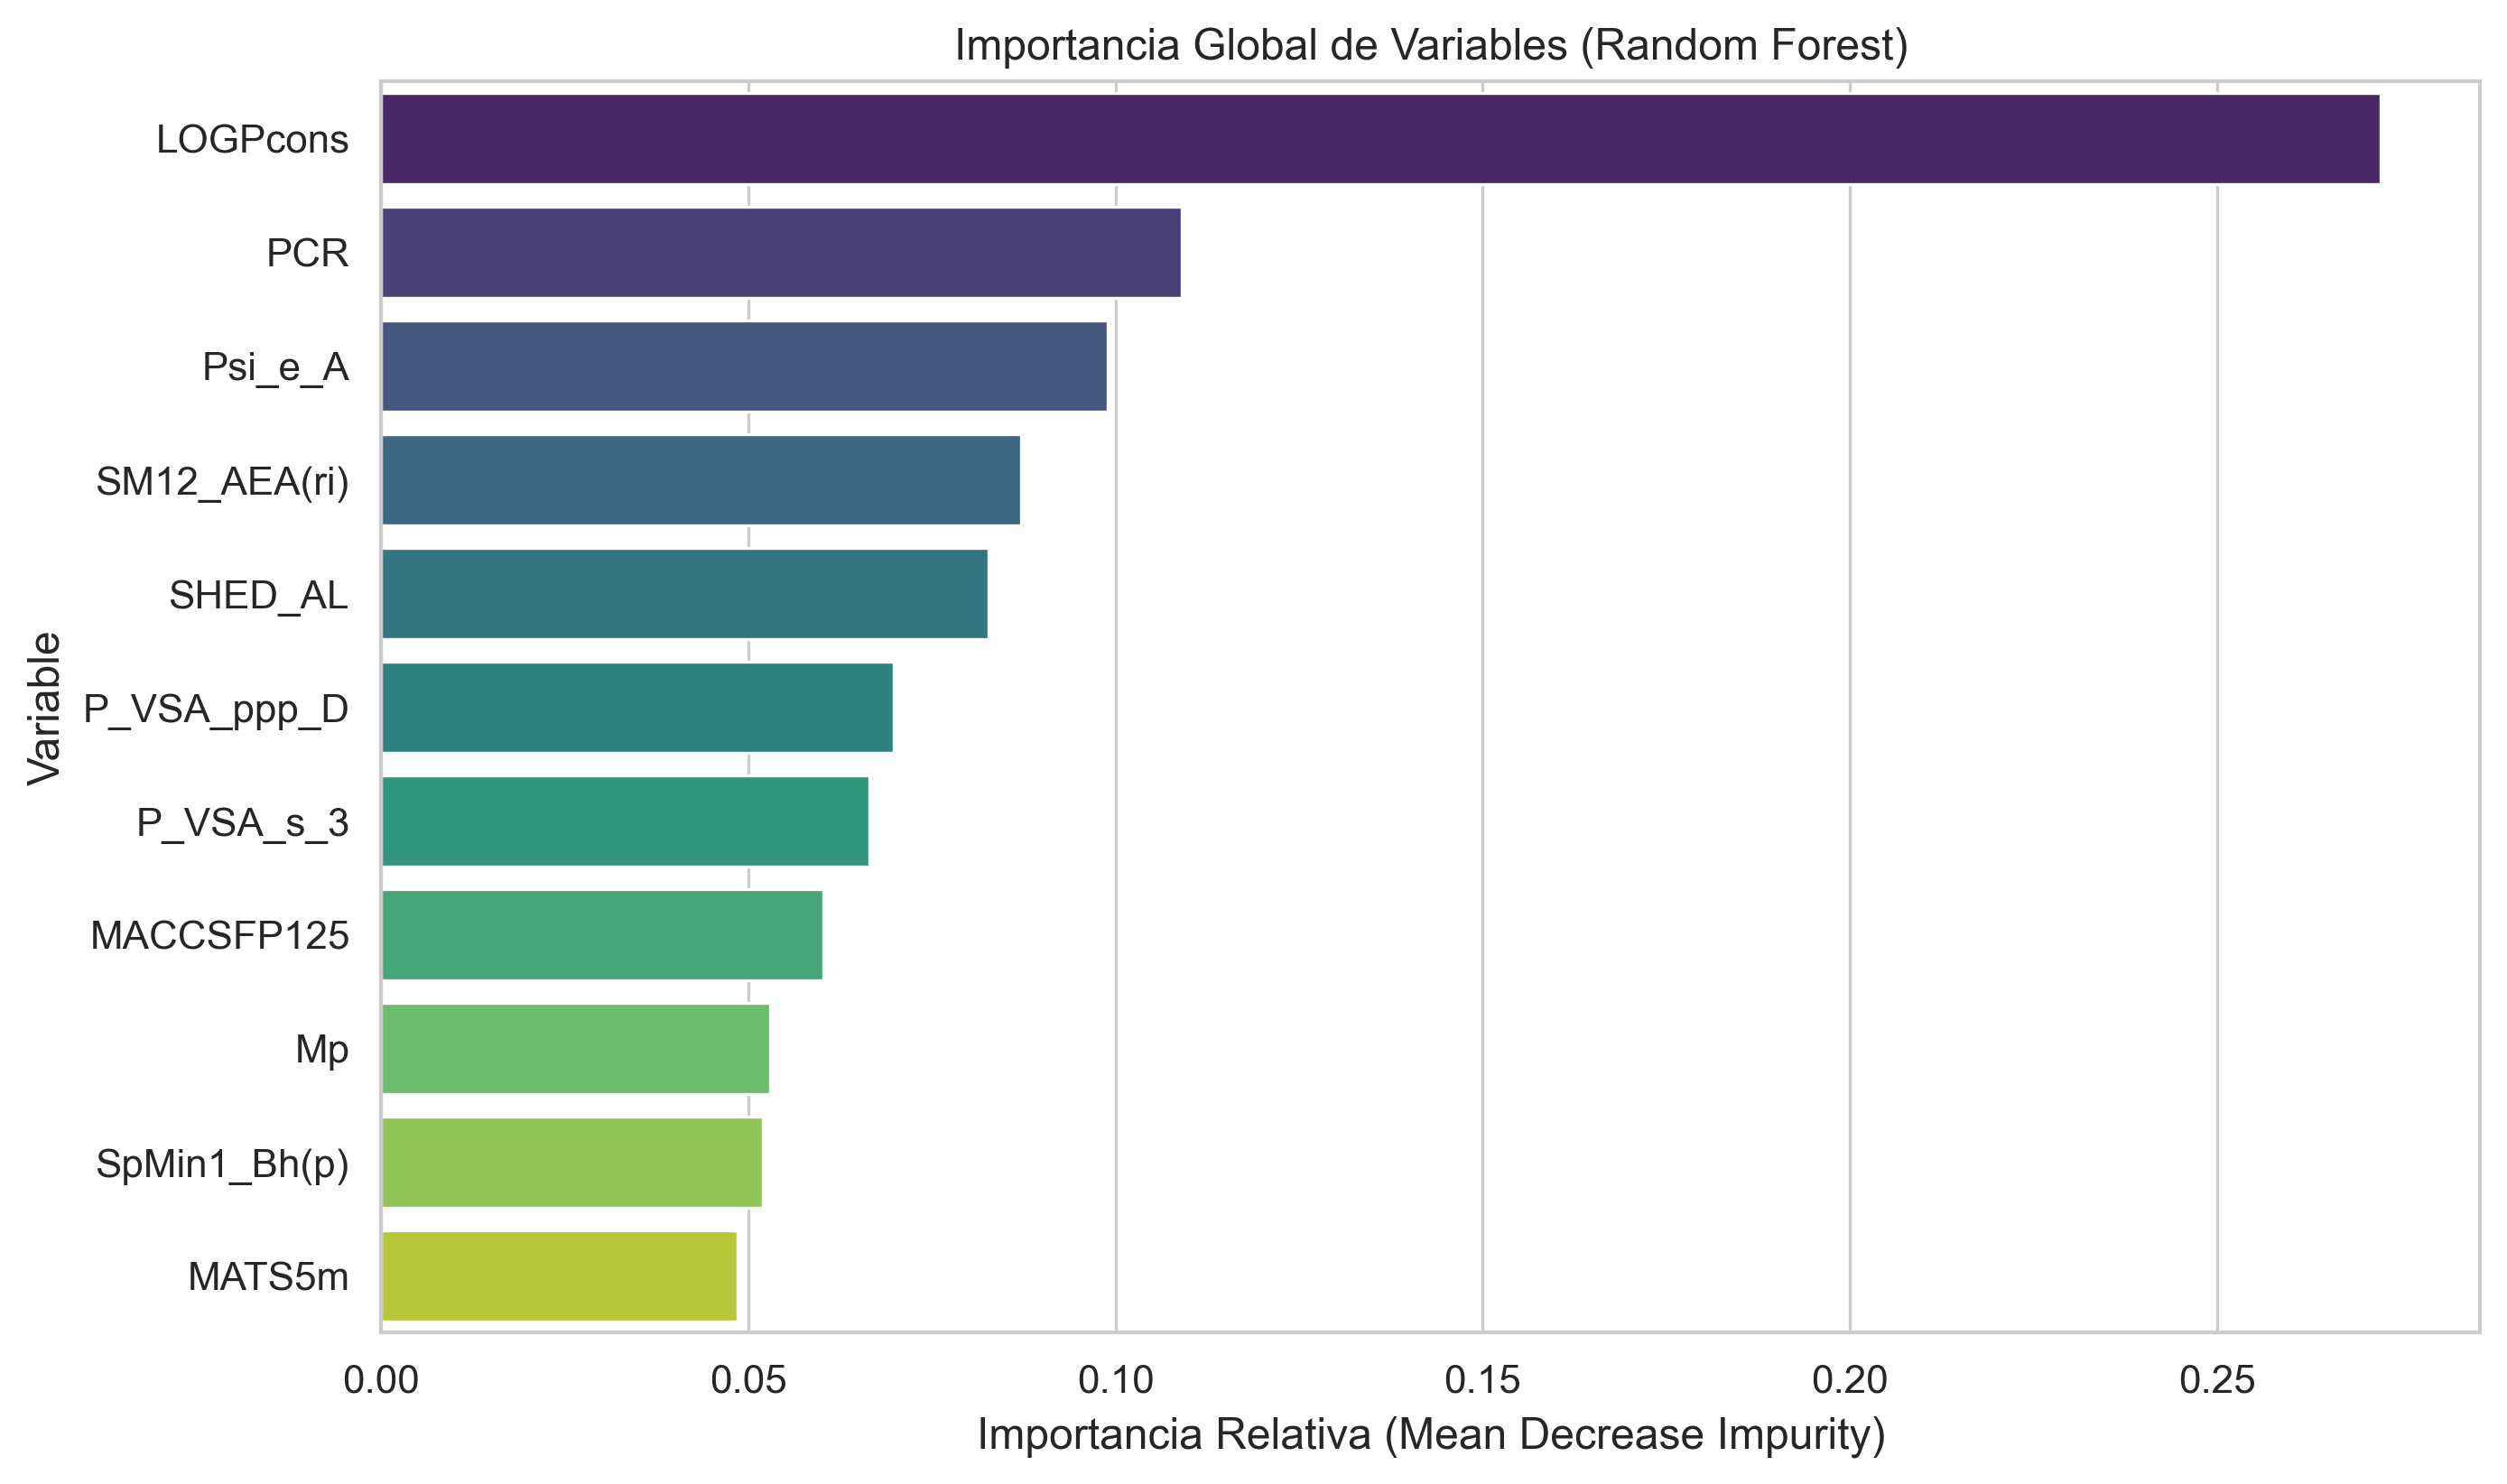

Calculando SHAP para Random Forest


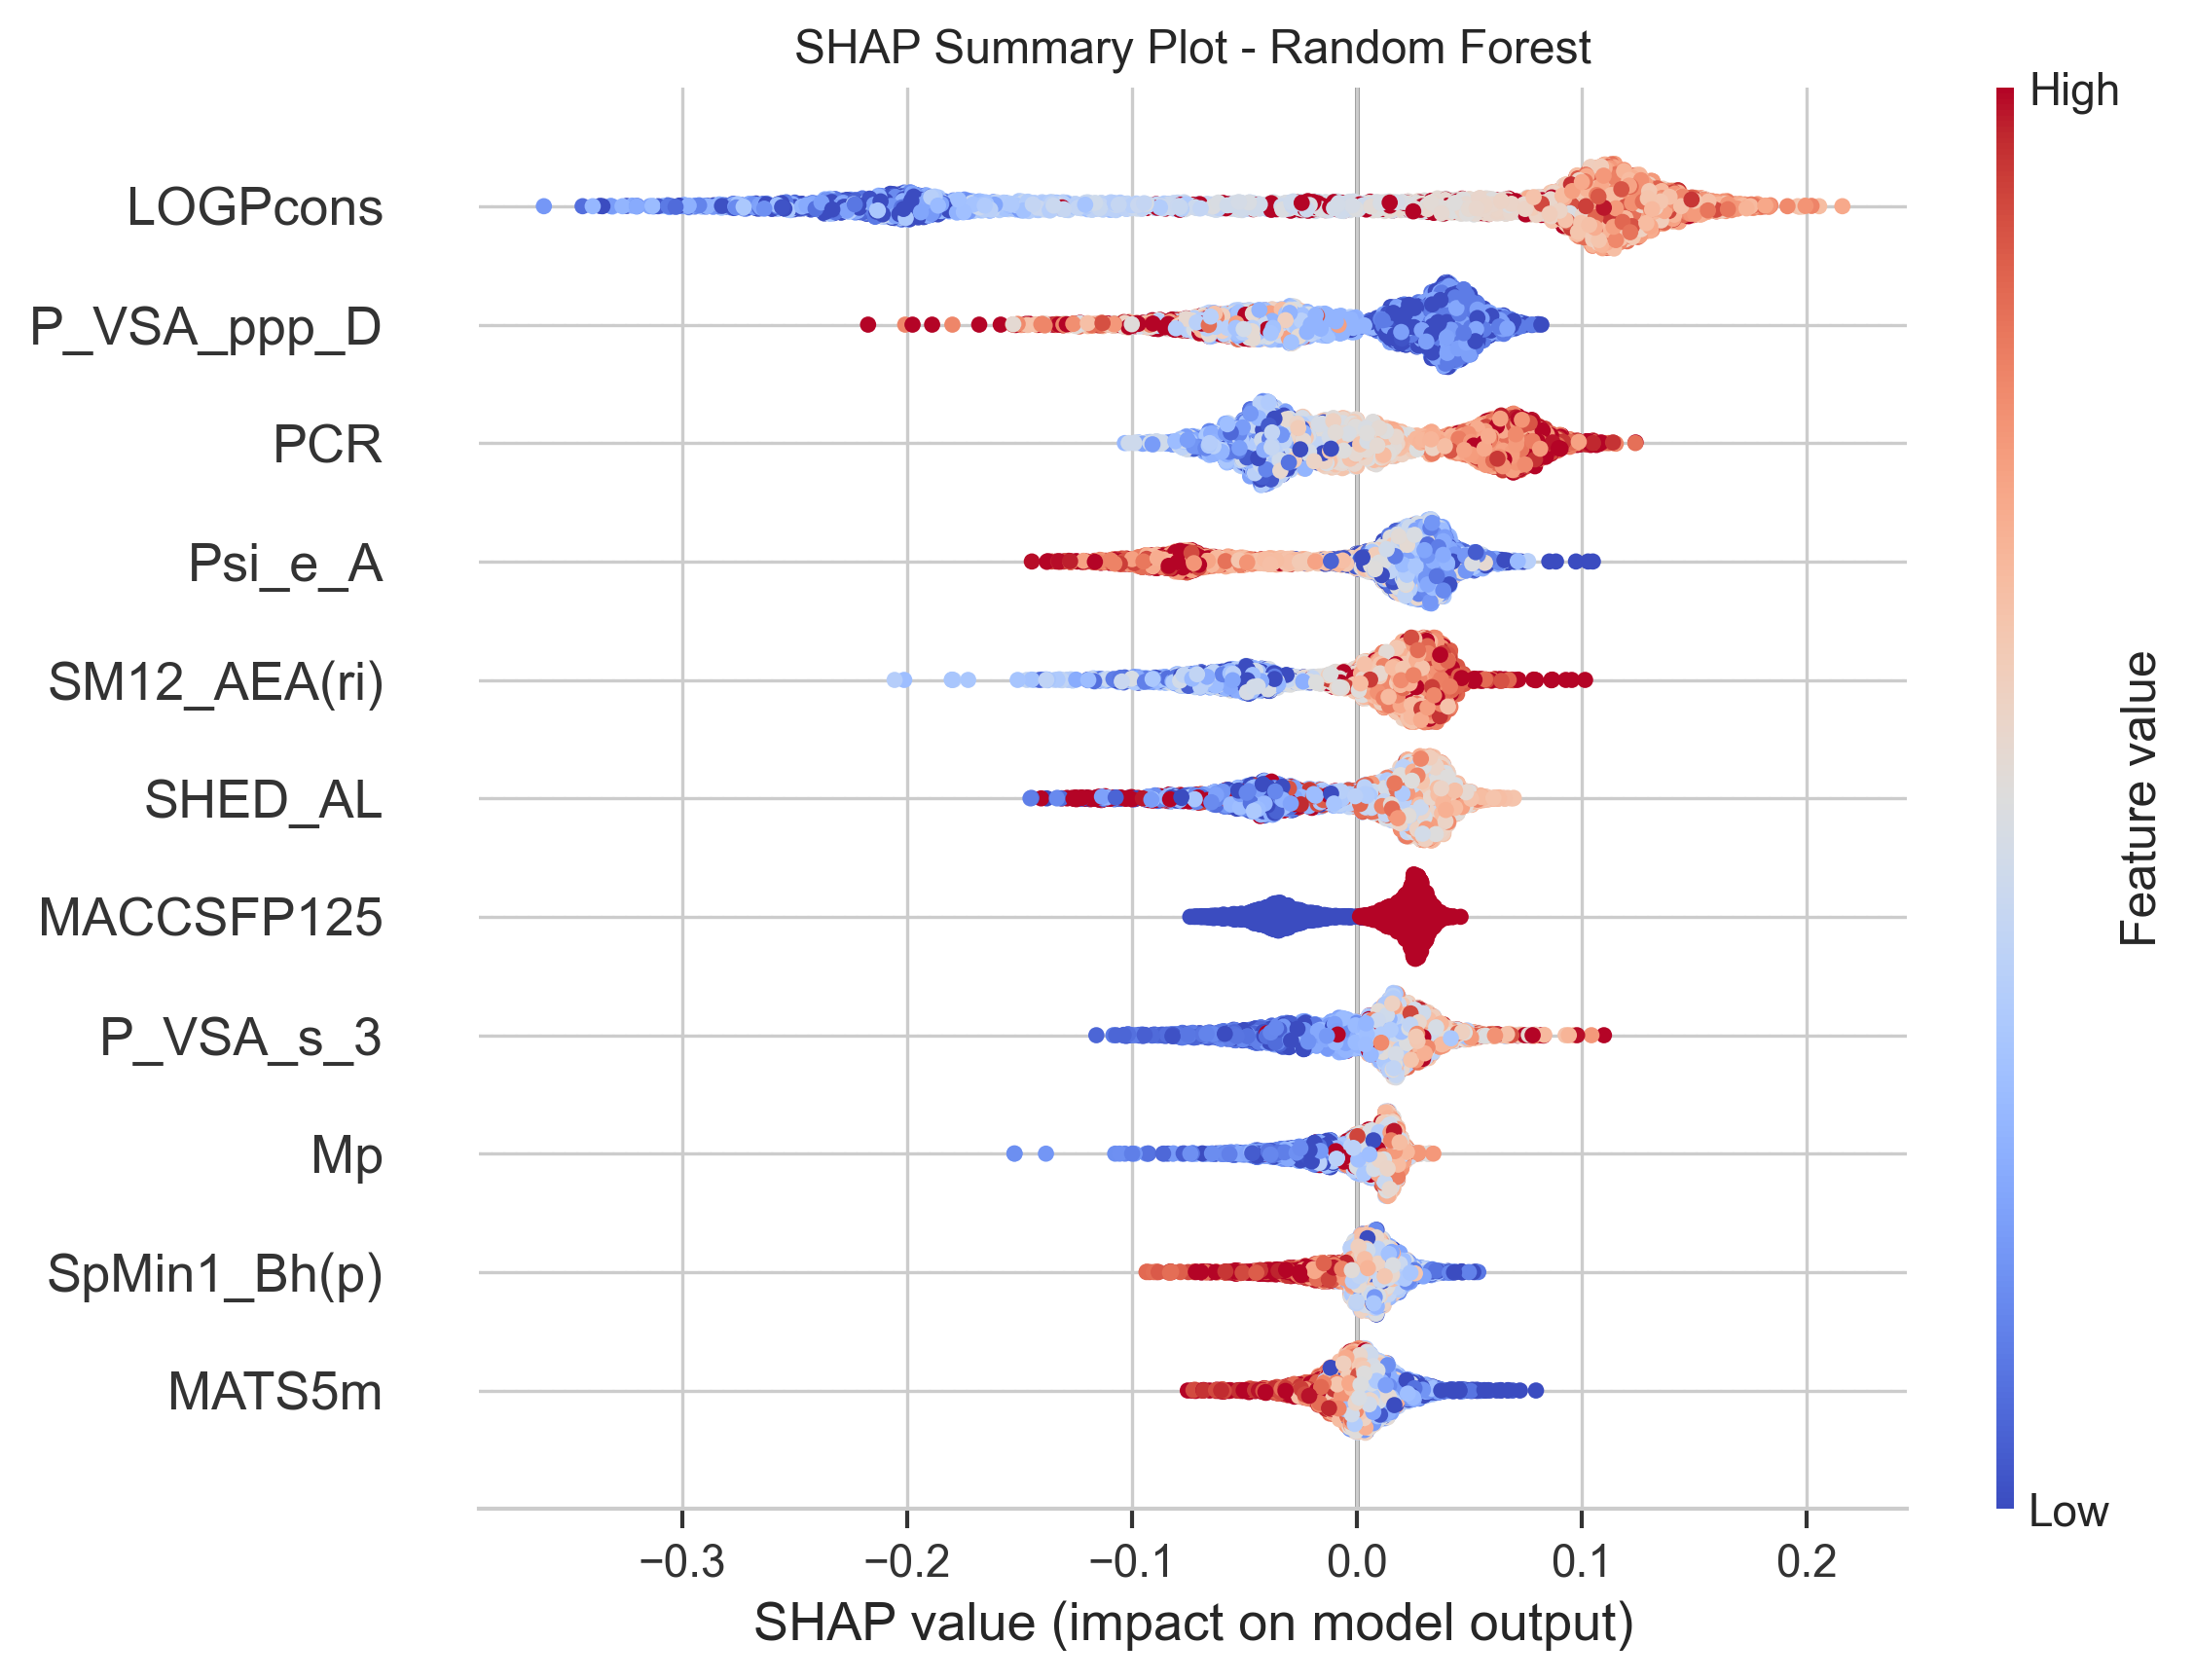

In [10]:
#IMPORTANCIA DE GINI (Feature Importance)
importances = pd.DataFrame({
    'Variable': features,
    'Importancia': best_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importances, palette='viridis')
plt.title("Importancia Global de Variables (Random Forest)")
plt.xlabel("Importancia Relativa (Mean Decrease Impurity)")
plt.show()

#SHAP VALUES
print("Calculando SHAP para Random Forest")
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

#Lógica para corregir dimensiones (Lista vs Array)
vals_to_plot = None
if isinstance(shap_values, list):
    vals_to_plot = shap_values[1] # Clase 1
elif len(np.array(shap_values).shape) == 3:
    vals_to_plot = shap_values[:, :, 1] # Clase 1
else:
    vals_to_plot = shap_values

plt.figure()
plt.title("SHAP Summary Plot - Random Forest")
shap.summary_plot(vals_to_plot, X_train, show=False, cmap='coolwarm')
plt.show()

Dominio de la Lipofilicidad: La variable LOGPcons aparece como el predictor más influyente. Esto es químicamente coherente, ya que la lipofilicidad es el principal determinante físico para cruzar una membrana lipídica (PAMPA).
Topología y Carga: Variables como MACCSFP125 (huella estructural) y P_VSA_ppp_D (distribución de carga/potencial) complementan la predicción, ajustando los casos donde el LogP por sí solo no es suficiente.

## Dominio de aplicabilidad

Evaluando Dominio de Aplicabilidad


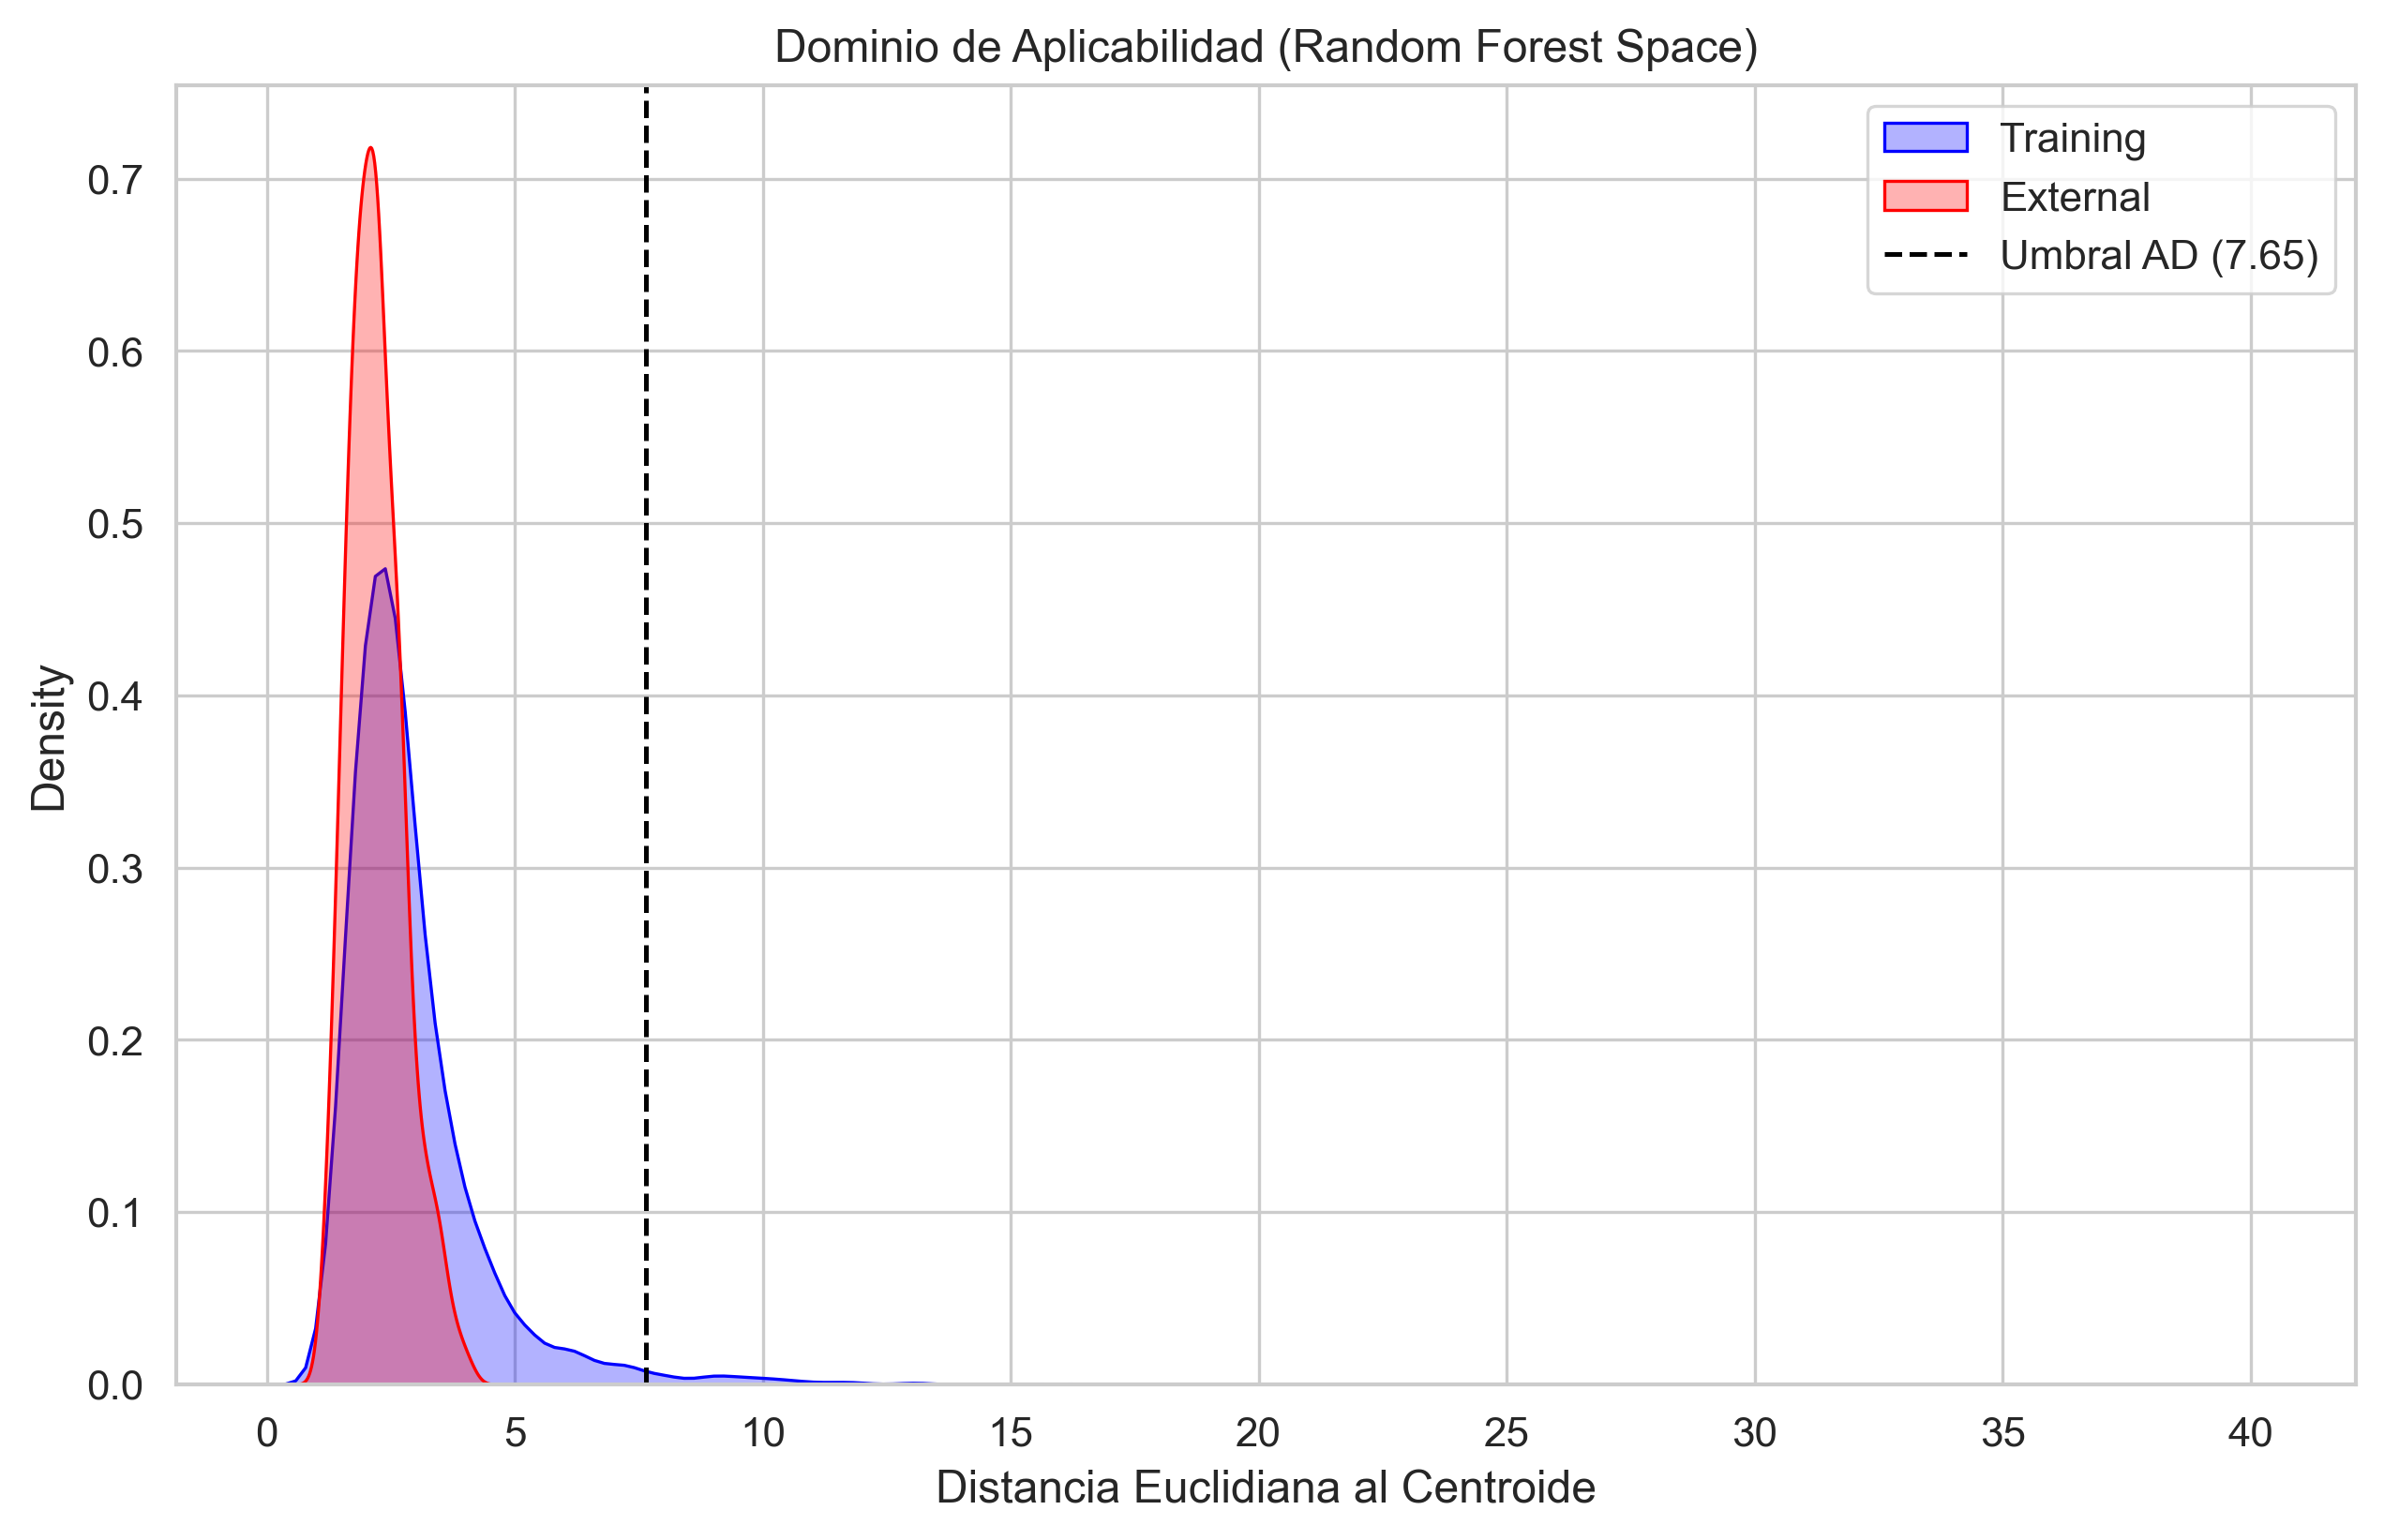

📉 Compuestos externos fuera del dominio: 0 de 486 (0.0%)


In [11]:
print("Evaluando Dominio de Aplicabilidad")

# 1. Estandarización
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_ext_sc = scaler.transform(X_ext)
# 2. Cálculo de Distancias
centroid = np.mean(X_train_sc, axis=0).reshape(1, -1)
dist_train = cdist(X_train_sc, centroid, 'euclidean')
dist_ext = cdist(X_ext_sc, centroid, 'euclidean')
# 3. Umbral de confiabilidad
limit_ad = np.mean(dist_train) + 3 * np.std(dist_train)
# 4. Gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(dist_train.flatten(), fill=True, color='blue', label='Training', alpha=0.3)
sns.kdeplot(dist_ext.flatten(), fill=True, color='red', label='External', alpha=0.3)
plt.axvline(limit_ad, color='black', linestyle='--', label=f'Umbral AD ({limit_ad:.2f})')
plt.xlabel('Distancia Euclidiana al Centroide')
plt.title('Dominio de Aplicabilidad (Random Forest Space)')
plt.legend()
plt.show()
# 5. Conteo
n_out = np.sum(dist_ext > limit_ad)
print(f"📉 Compuestos externos fuera del dominio: {n_out} de {len(dist_ext)} ({n_out/len(dist_ext)*100:.1f}%)")

Este RF se establece como una herramienta de Virtual Screening . Su arquitectura maximiza la recuperación de compuestos activos (Sensibilidad > 97%) y ofrece una explicabilidad química clara a través de sus variables más importantes, superando las limitaciones de los modelos de "caja negra" más complejos al tener solo 11 variables que explica fisicoquimicamente la permeabilidad